# Time Series Clustering with K-Means and Euclidean Distance Matrix for total (n2) with Engineered Features


This notebook provides a clustering for the total (n2) column of the acceleration data of scripted trips only. The exact approach can be seen here.

----
**Specification of experiment:**
- scripted trips only
- n2 column of acceleration data was used
- Euclidean Distance was calculated
- Feature Engineering with Quantiles, Standard deviation, maximum break/acceleration length

-----
**Results:**

1) KMeans Clustering with 3 Clusters:
 - 'Estimated number of clusters: 3',
 - 'True number of clusters: 3' *,
 - 'Homogeneity: 0.897',
 - 'Completeness: 0.510',
 - 'V-measure: 0.650',
 - 'Adjusted MI: 0.509',
 - 'Silhouette Coefficient: 0.800'


*Assume that transport modes are true clusters

In [32]:
# Load the "autoreload" extension
%load_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 1

import os
import sys
from dotenv import load_dotenv, find_dotenv
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
#Visualisation Libraries
%matplotlib inline
# Uncomment if you want interactive 3D plots --> does not work in the github rendering
#%matplotlib notebook
from copy import deepcopy

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
matplotlib.style.use('ggplot')
import seaborn as sns

from IPython.display import display_markdown

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

%aimport visualization.visualize
from visualization.visualize import get_color_encoding
from visualization.visualize import plot_timeseries_clustering
from visualization.visualize import get_plot_timeseries_clustering_variables
from visualization.visualize import get_distribution_of_cluster_labels_for
from visualization.visualize import plot_distribution_of_cluster_labels_for_target
from visualization.visualize import plot_all_trips_with_cluster_coloring
from visualization.visualize import plot_2D_tsne_with_coloring_per_targets



%aimport data.preprocessing
from data.preprocessing import Preprocessor
%aimport data.download
from data.download import DatasetDownloader
%aimport utils.utilities
from utils.utilities import get_cluster_labels
%aimport features.build_features
from features.build_features import calculate_maximum_break_length
from features.build_features import calculate_maximum_acceleration_length
%aimport models.cluster
from models.cluster import get_clustering_performance

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data_dir = os.path.join(os.path.abspath(DatasetDownloader.get_data_dir()))
file_path = os.path.join(data_dir, "preprocessed","preprocessed_data.dat")

dfs = Preprocessor.restore_preprocessed_data_from_disk(file_path)

In [3]:
categorical_columns = ["mode","notes","scripted","token","trip_id"]

trips_cut_per_30_sec = Preprocessor.get_cut_trip_snippets_for_targets(dfs,["total"])[0]
scripted_trips_only = trips_cut_per_30_sec[trips_cut_per_30_sec["scripted"] == 1]
scripted_trips_only = scripted_trips_only.reset_index(drop=True)

distance_matrix = Preprocessor.calculate_distance_for_n2(scripted_trips_only, metric="euclidean")
distances_only = distance_matrix.drop(categorical_columns,axis=1)

--------
# Feature Engineering

## Calculate Maximum Break Length as Longest decreasing pattern

Calculate break duration in seconds

In [4]:
scripted_trips_copy = scripted_trips_only.drop(categorical_columns,axis=1)
longest_decreasing_patterns = calculate_maximum_break_length(scripted_trips_copy,
                                                             threshold=3)


## Calculate Maximum Acceleration Length == Longest increasing pattern

Calculate acceleration duration in seconds

In [5]:
longest_increasing_patterns = calculate_maximum_acceleration_length(scripted_trips_copy,
                                                             threshold=3)


## Summary Statistics of euclidean distances:

In [6]:
percentiles=[0.1*(i+1) for i in range(10)]
summary = distances_only.transpose().describe(percentiles=percentiles).T
summary = summary.drop(["count","min","max","mean"],axis=1)
summary.head()

,std,10%,20%,30.0%,40%,50%,60.0%,70%,80%,90%,100%
0,45.061287,3.610770,6.760964,10.500196,12.577645,15.733230,17.148232,54.150599,102.440698,112.152077,161.944225
1,44.920779,5.801042,7.136099,9.403037,11.671881,14.076364,15.372234,54.156080,101.997231,111.678237,160.342251
2,45.221465,4.131189,5.964888,9.451812,11.626179,14.426404,15.761094,53.832504,101.804602,111.827993,161.368728
3,45.265942,5.089719,6.662610,7.803089,9.774377,12.297512,13.692647,53.121159,101.129707,111.193785,159.448943
4,44.961413,6.208727,7.607290,8.426689,10.078955,12.347625,13.698369,53.492378,101.022031,111.266889,160.030718


In [7]:
summary["longest_break_period"] = np.array(longest_decreasing_patterns,dtype=np.float32)
summary["longest_acceleration_period"] = np.array(longest_increasing_patterns,dtype=np.float32)
for colname in categorical_columns:
    summary[colname] = distance_matrix[colname]


### Summary of maximum break period and longest acceleration period per transport mode

In [8]:
summary.groupby("mode").describe()[["longest_break_period","longest_acceleration_period"]]

longest_break_period                                           \
                     count      mean       std  min  25%  50%   75%   
mode                                                                  
METRO                301.0  0.765947  0.942742  0.2  0.2  0.4  0.80   
TRAM                 328.0  1.347409  4.918779  0.0  0.2  0.4  1.15   
WALK                 282.0  0.719149  0.821782  0.2  0.2  0.4  0.80   

                 longest_acceleration_period                                   \
             max                       count      mean       std  min     25%   
mode                                                                            
METRO   4.700000                       301.0  3.327575  3.612772  0.0  1.2000   
TRAM   70.800003                       328.0  4.476982  5.659683  0.2  1.0500   
WALK    5.600000                       282.0  2.916844  2.391766  1.0  1.2625   

                               
        50%    75%        max  
mode                           
METRO  1.40  6.000  34.200001  
TRAM   4.20  6.200  51.500000  
WALK   1.45  5.175  11.550000

### Choose which features to use

In [9]:
features_used = summary

### Prepare features for clustering

In [10]:
features_used = features_used.drop(categorical_columns,axis=1)
features_used = pd.DataFrame(scale(features_used),columns=features_used.columns)
features_used.head(2)

,std,10%,20%,30.0%,40%,50%,60.0%,70%,80%,90%,100%,longest_break_period,longest_acceleration_period
0,0.702989,-0.667746,-0.638794,-0.600925,-0.594934,-0.606222,-0.633149,-0.583236,-0.497181,-0.538650,-0.295588,-0.217040,-0.616084
1,0.690462,-0.620268,-0.630539,-0.625433,-0.615447,-0.644627,-0.674872,-0.583041,-0.519937,-0.563428,-0.403568,-0.118507,-0.545385


------
# Model Building

## Create Base Model with KMeans Clustering

Use summaries of each distance

In [11]:
from sklearn.cluster import KMeans
random_state = 0

kmeans = KMeans(n_clusters=3, random_state=random_state).fit(features_used)
cluster_labels = kmeans.labels_
distance_matrix["cluster_labels"]=cluster_labels

-----
## Summary Statistics for KMeans Clustering:

Here the performance is evaluated in regard to the "true labels" which here corresponds to the transport mode.

In [34]:
cluster_performance = get_clustering_performance(features_used, cluster_labels,
                                                 true_labels=distance_matrix["mode"])
for line in cluster_performance:
    display_markdown(" - {}".format(line),raw=True)

 - Estimated number of clusters: 3

 - True number of clusters: 3

 - Homogeneity: 0.897

 - Completeness: 0.510

 - V-measure: 0.650

 - Adjusted MI: 0.509

 - Silhouette Coefficient: 0.799

## Visualise Clustering on 2D - TSNE Plot:

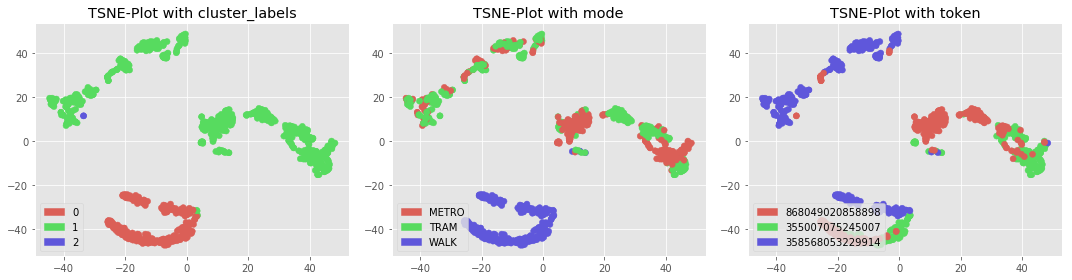

In [21]:
color_encodings = distance_matrix.loc[:,["cluster_labels","mode","token"]]
plot_2D_tsne_with_coloring_per_targets(features_used, color_encodings)

## Inspect the distribution of modes to cluster label for all trips

From this we can see that it the clustering is not distinct between "WALK" and "TRAM"

In [15]:
mode_dist_df = get_distribution_of_cluster_labels_for("mode", distance_matrix)
mode_dist_df

,count_cluster_0,count_cluster_1,count_cluster_2,mode
0,0.0,301.0,0.0,METRO
1,271.0,11.0,0.0,WALK
2,0.0,326.0,2.0,TRAM


### Plot distribution of cluster labels for transport modes

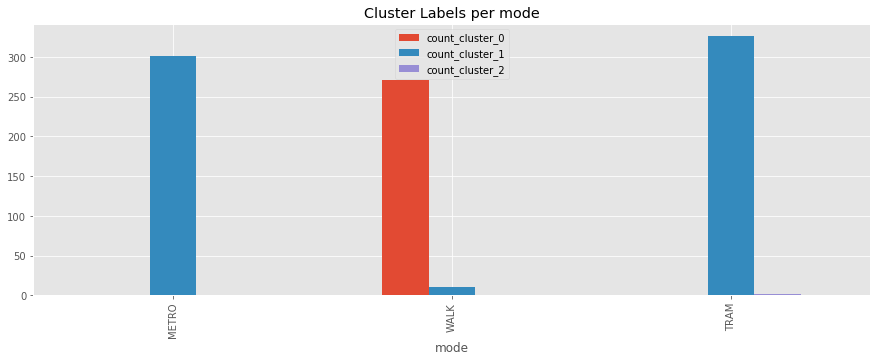

In [16]:
plot_distribution_of_cluster_labels_for_target("mode", distance_matrix)

### Plot distribution of cluster labels for tokens

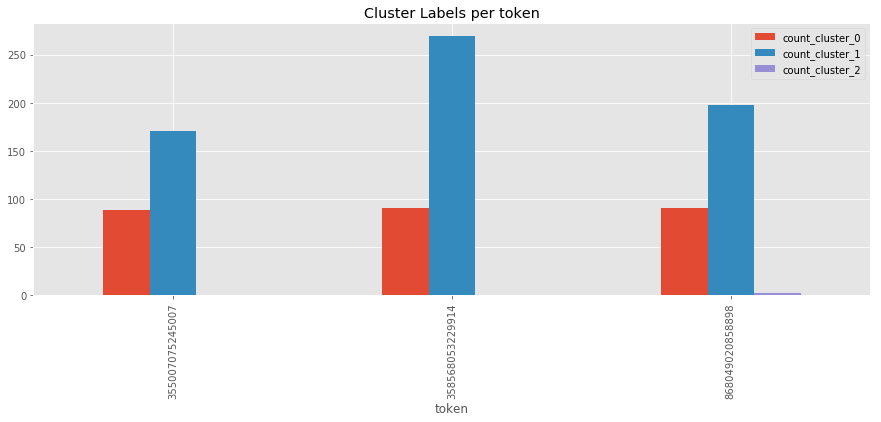

In [17]:
plot_distribution_of_cluster_labels_for_target("token", distance_matrix)

------
## Plot all trips with their clustering labels

C:\Users\Lukas\.conda\envs\Tensorflow\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



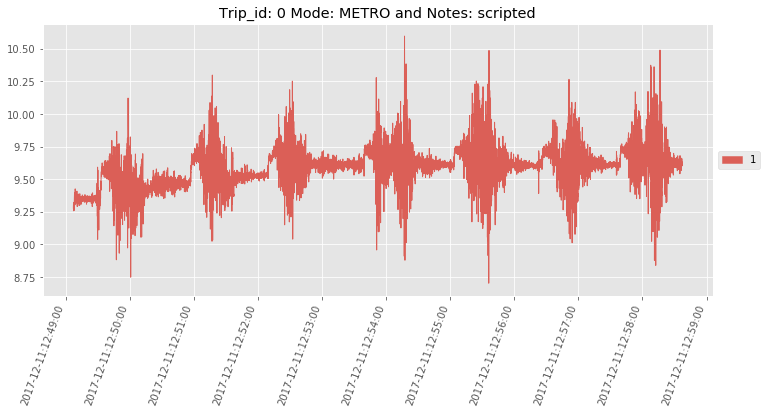

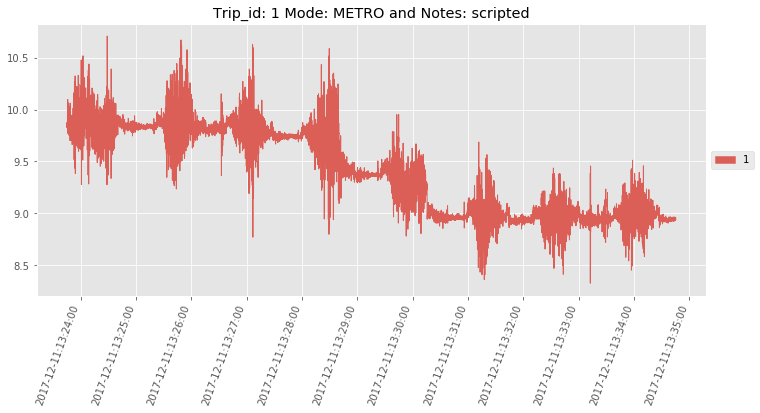

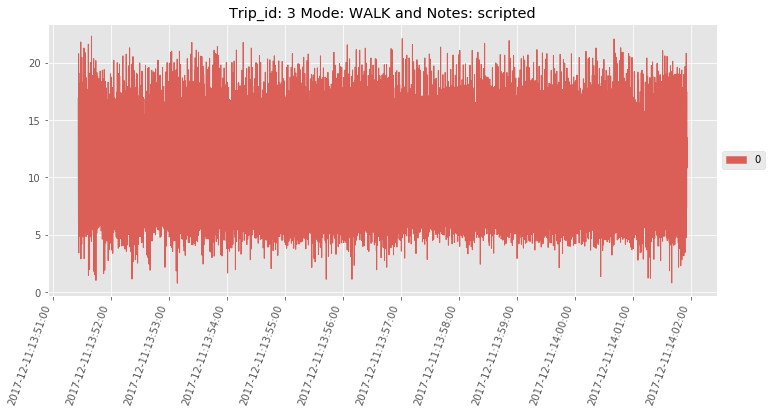

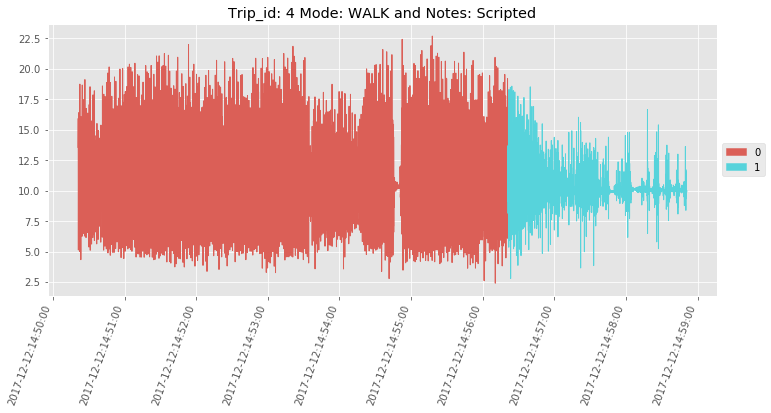

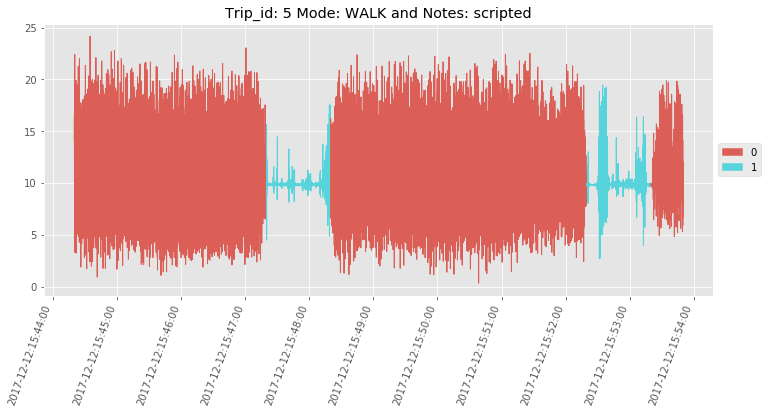

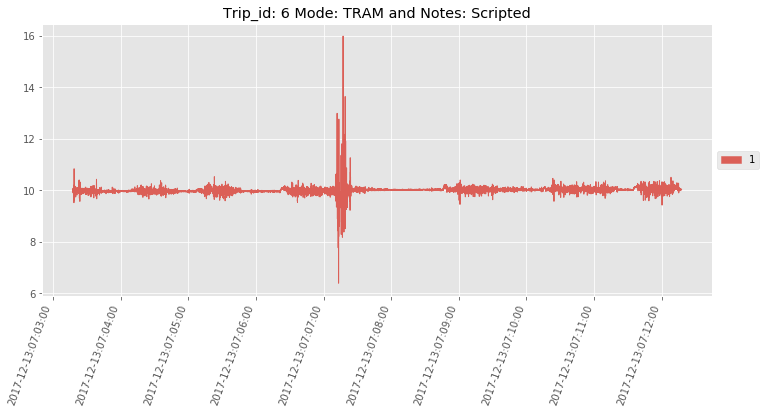

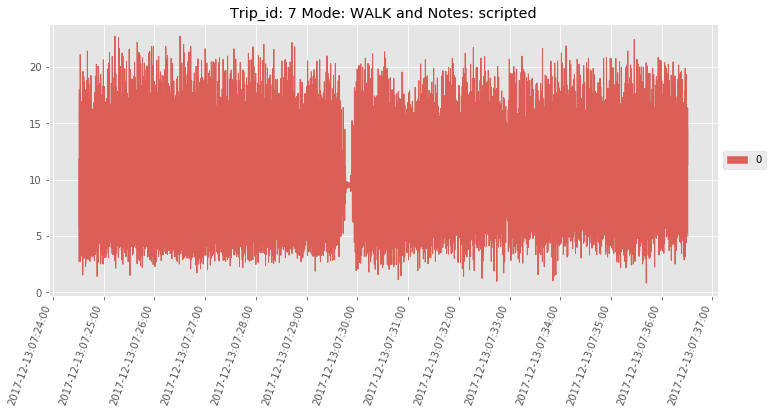

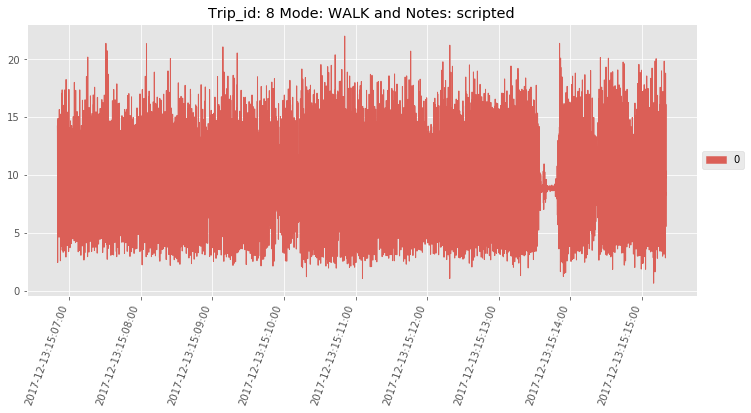

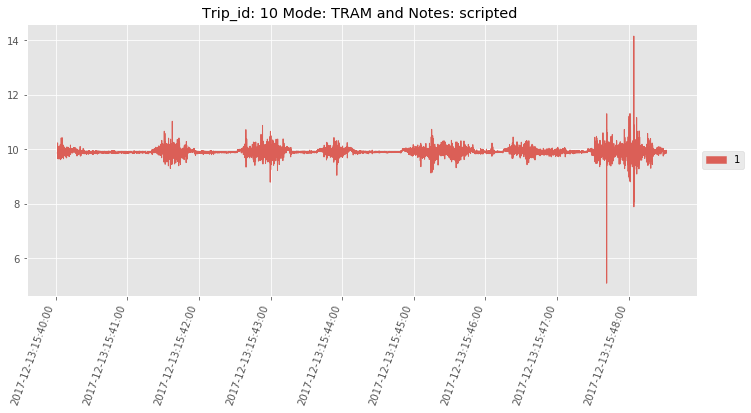

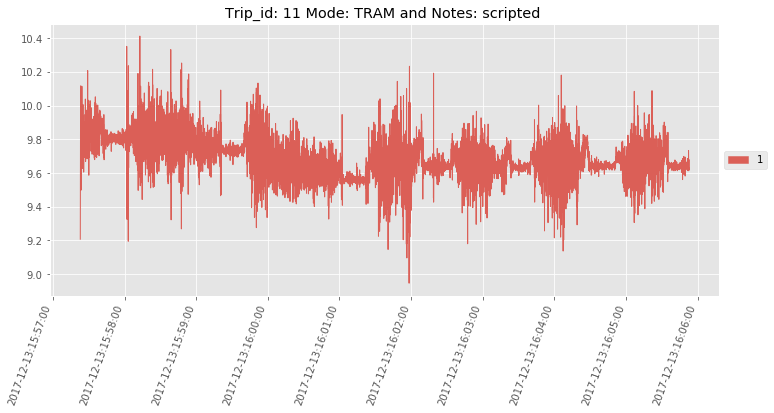

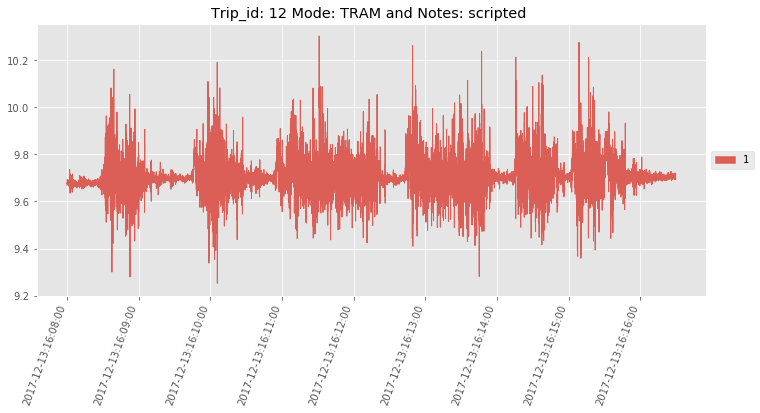

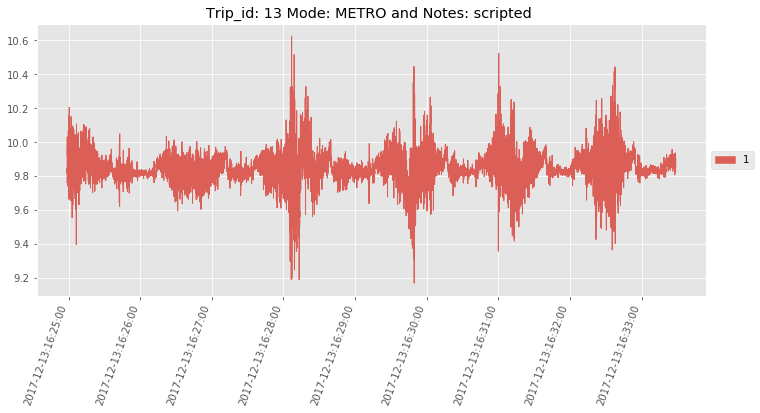

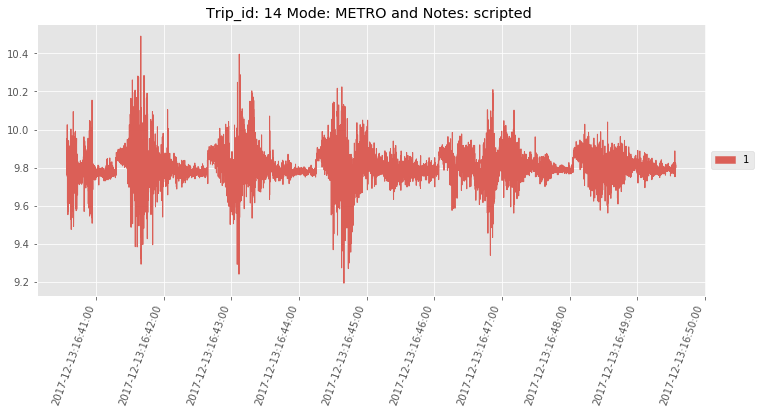

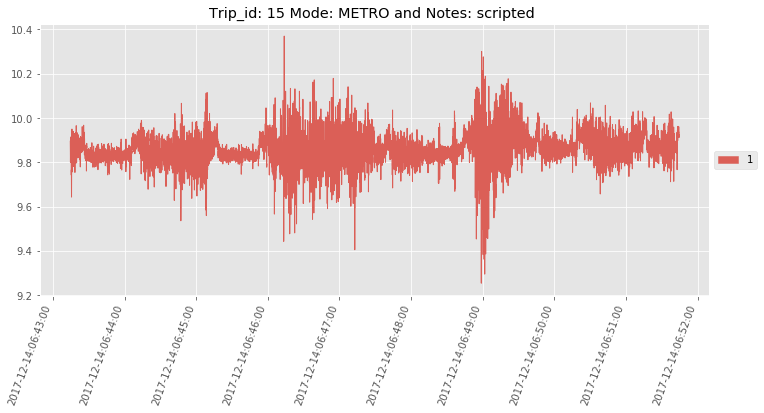

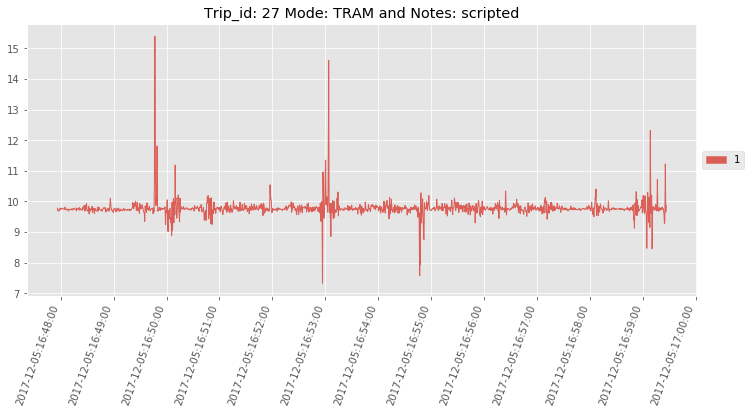

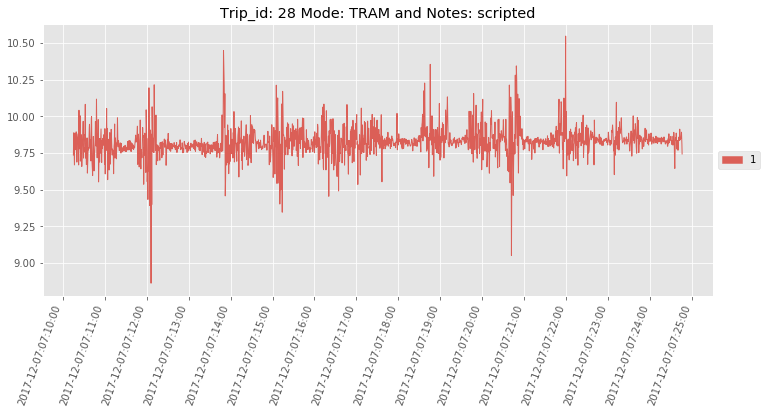

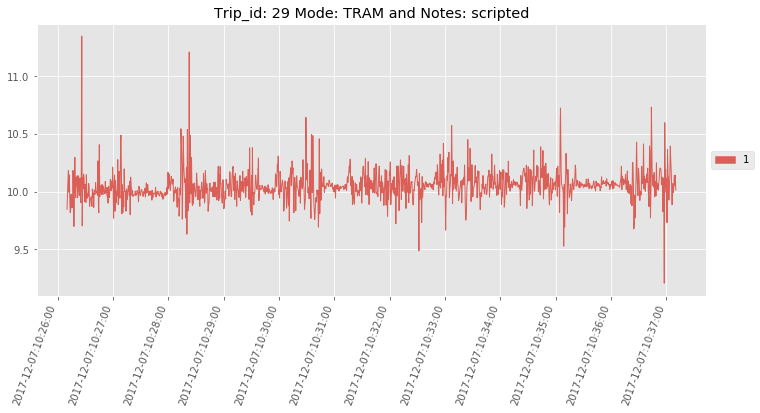

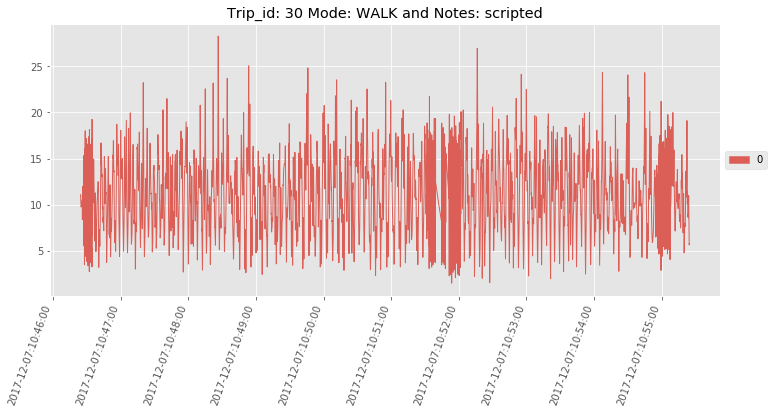

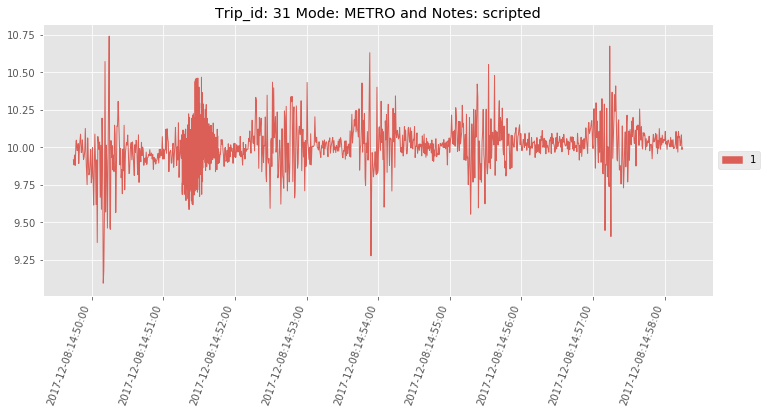

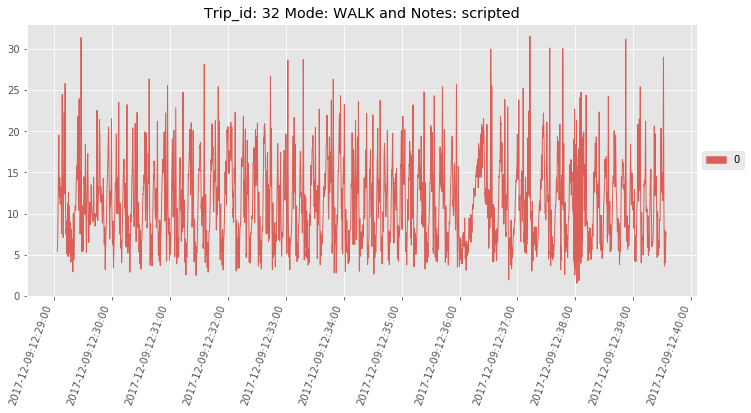

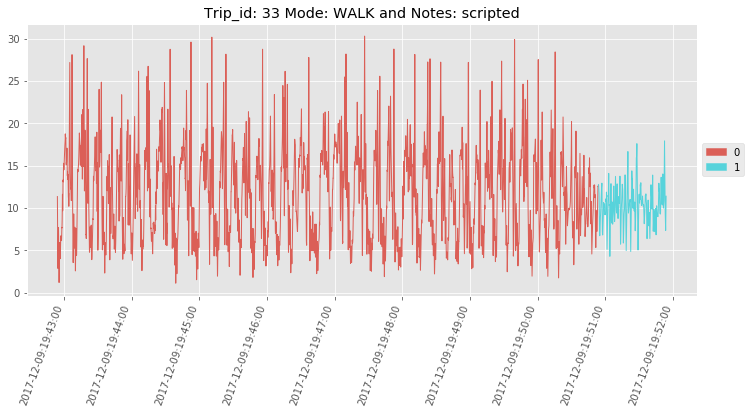

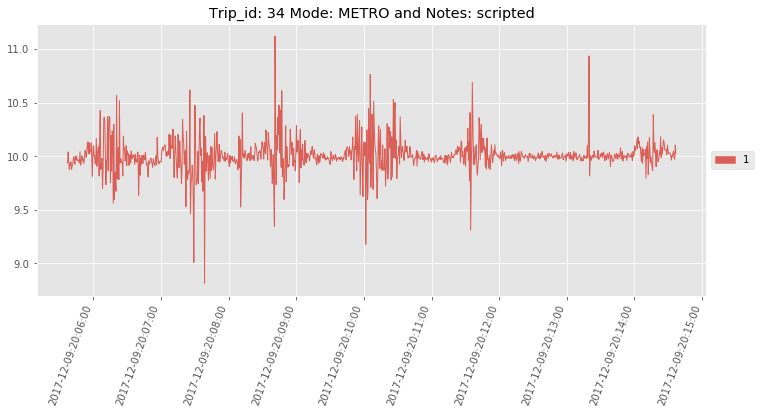

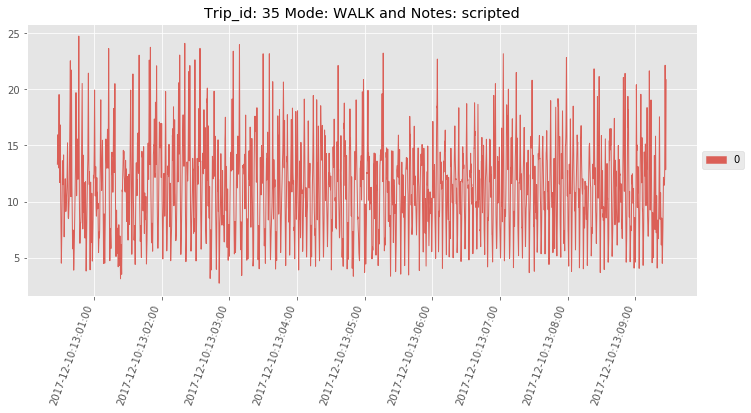

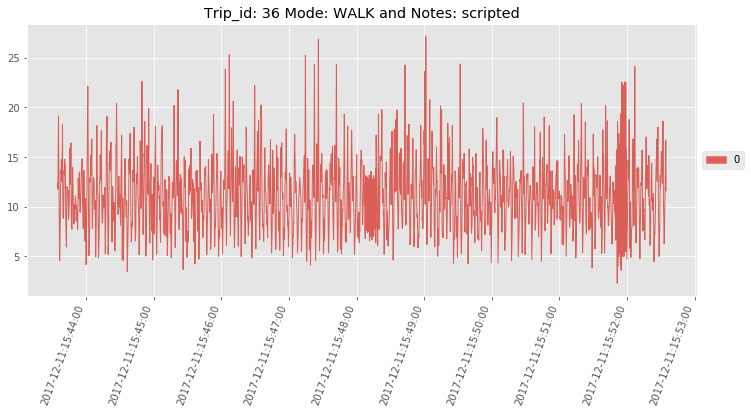

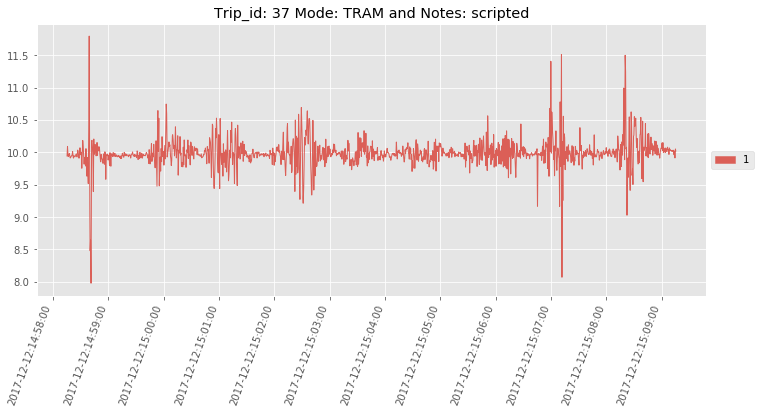

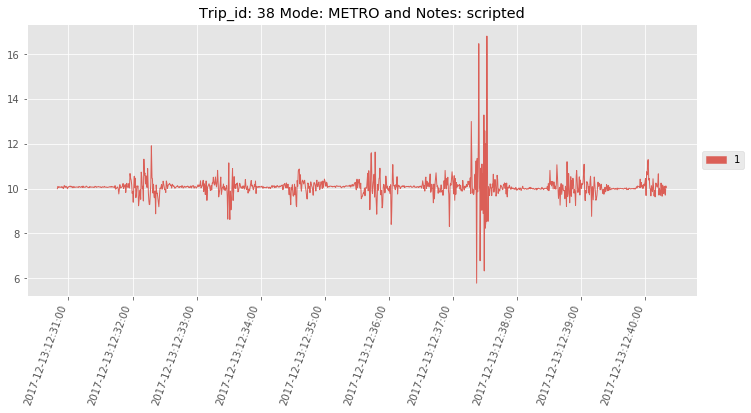

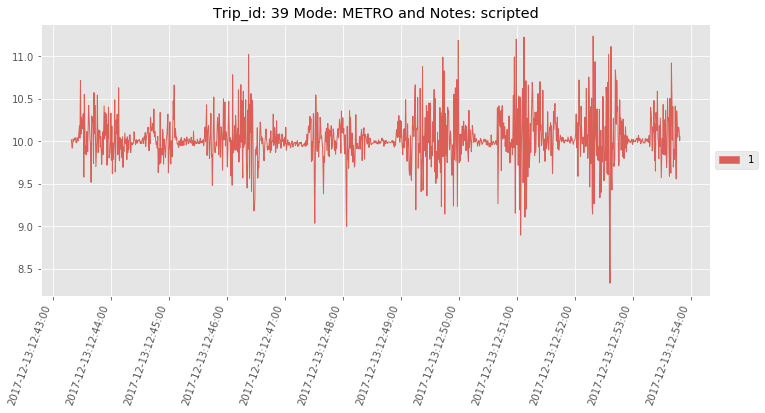

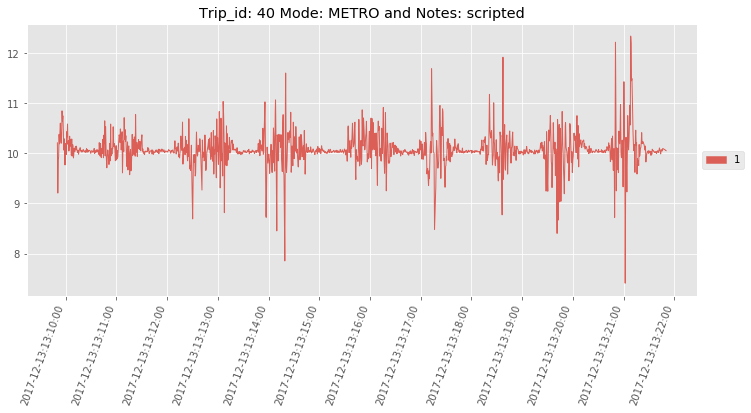

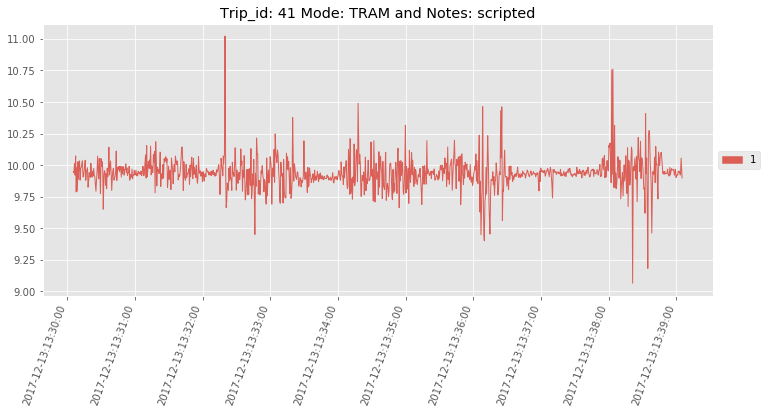

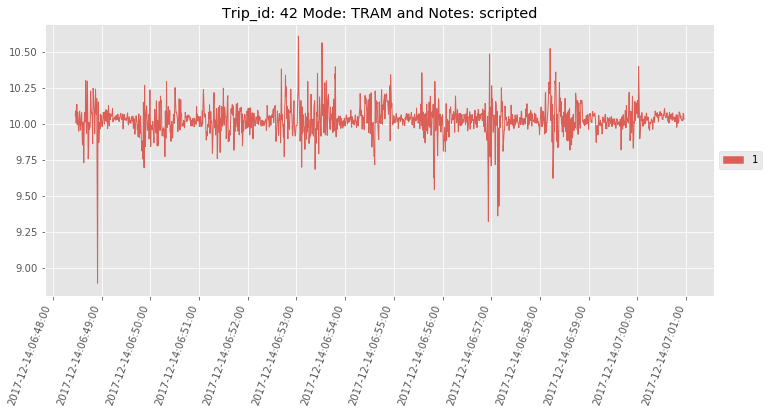

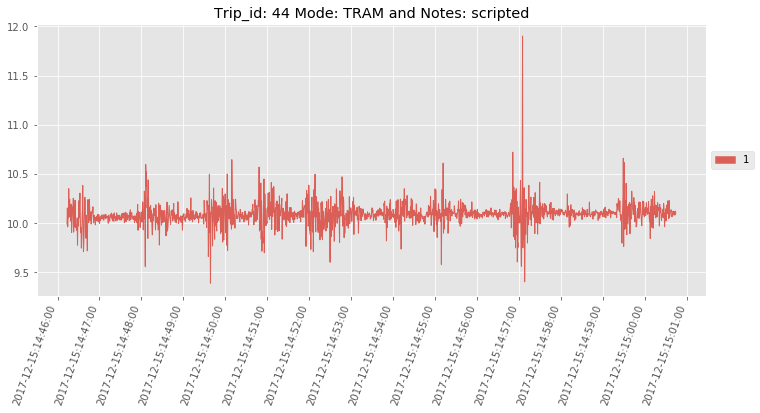

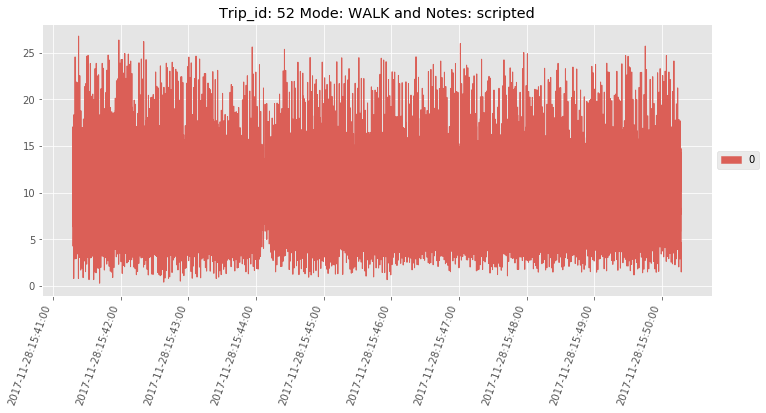

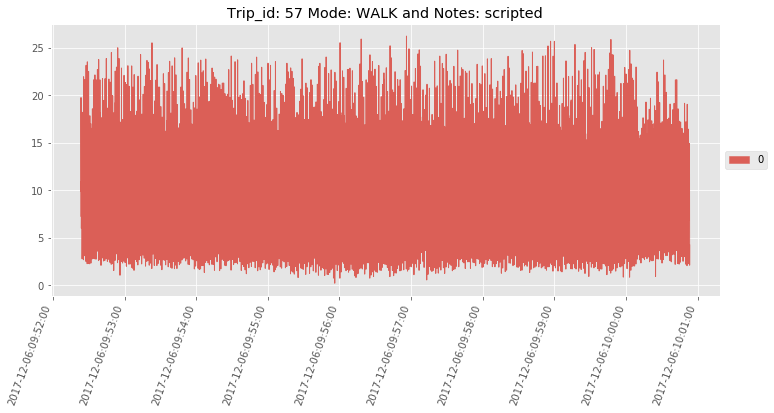

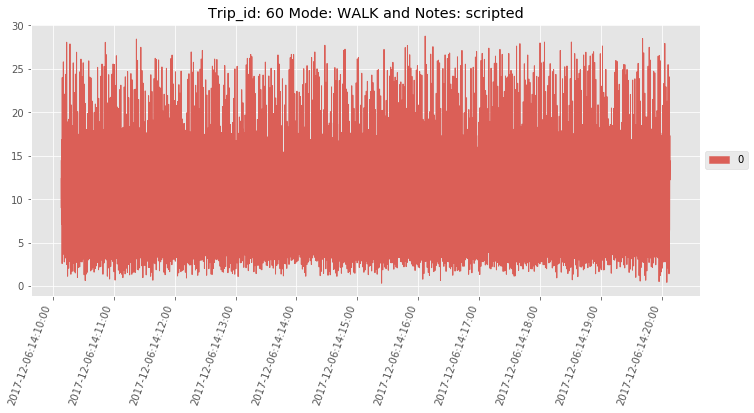

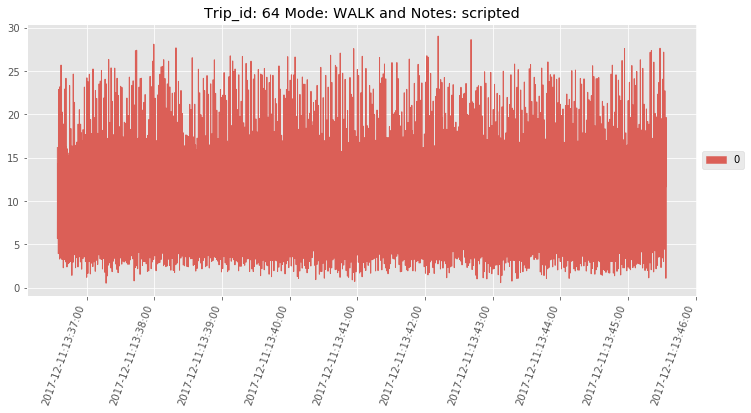

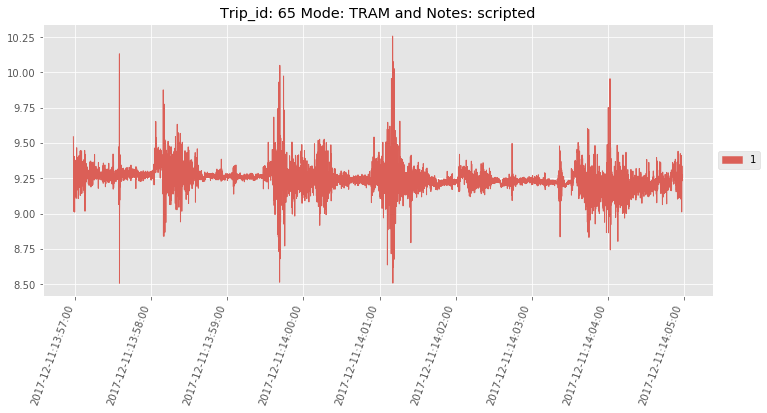

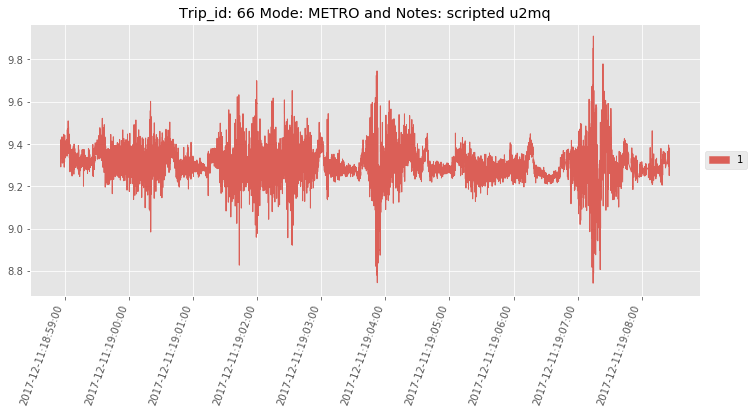

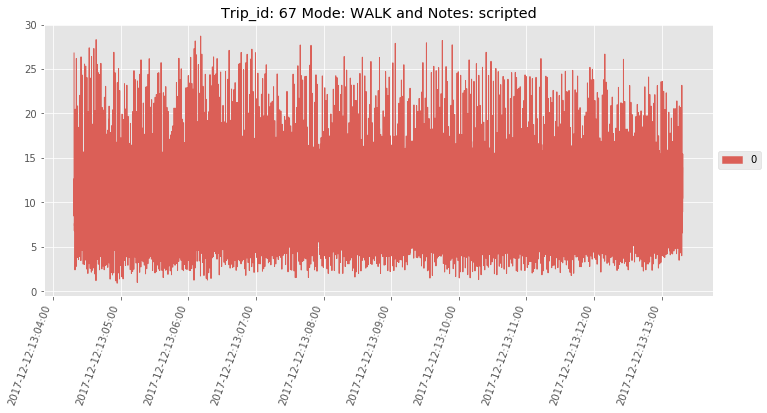

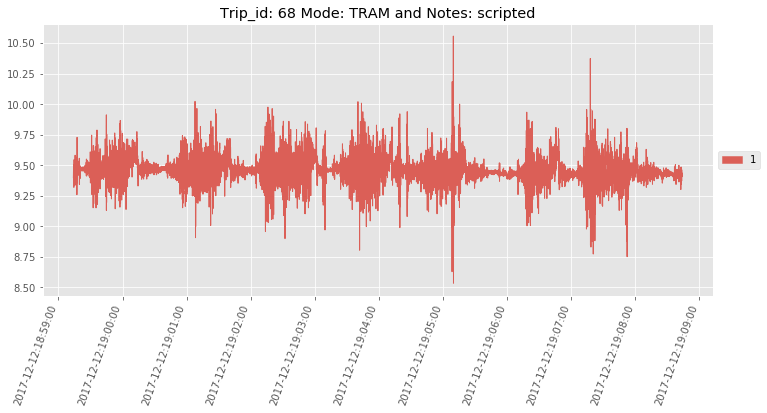

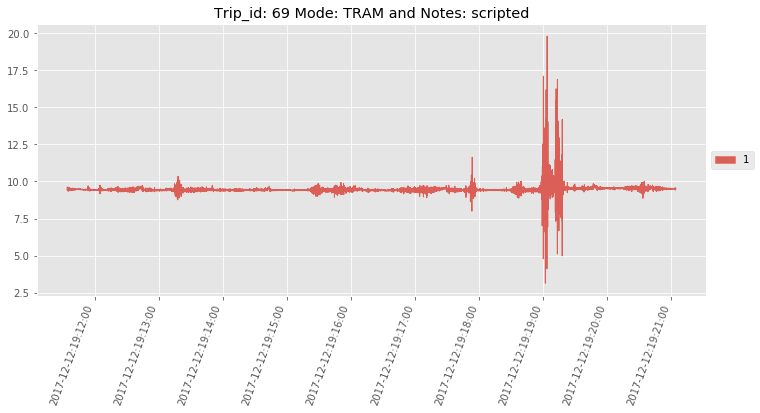

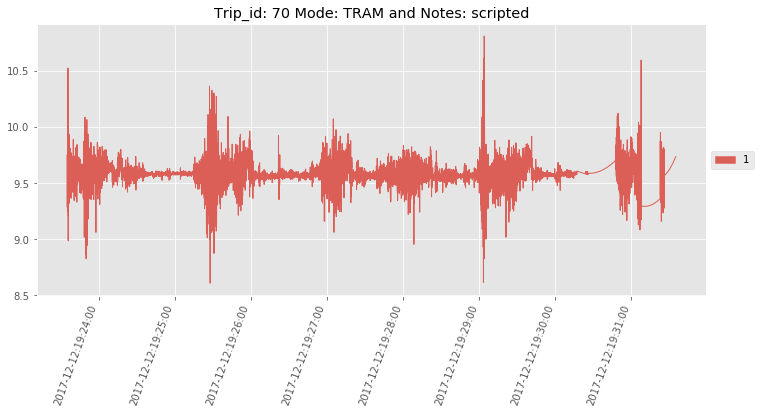

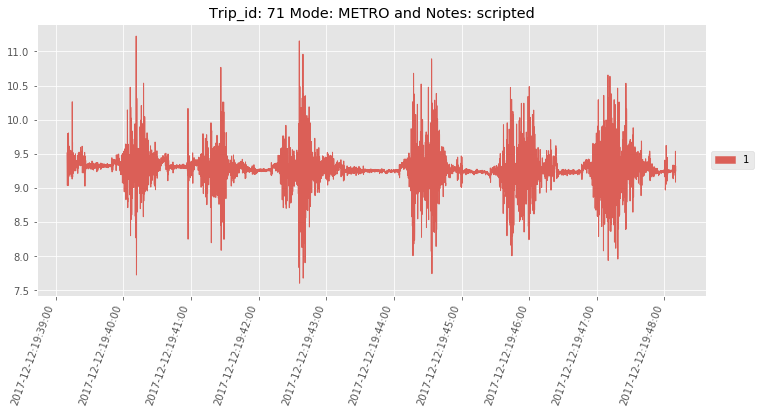

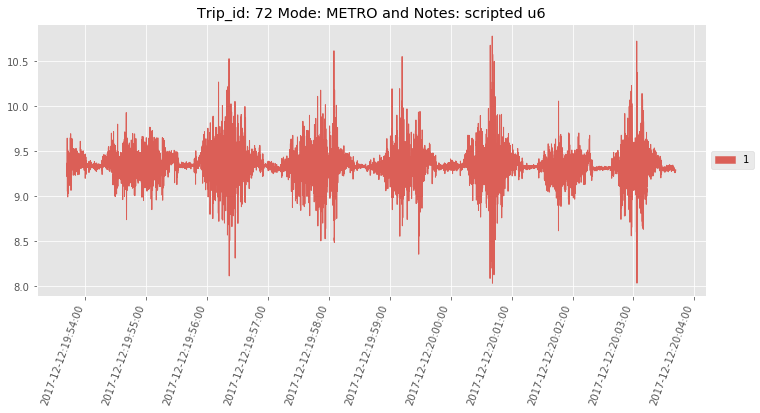

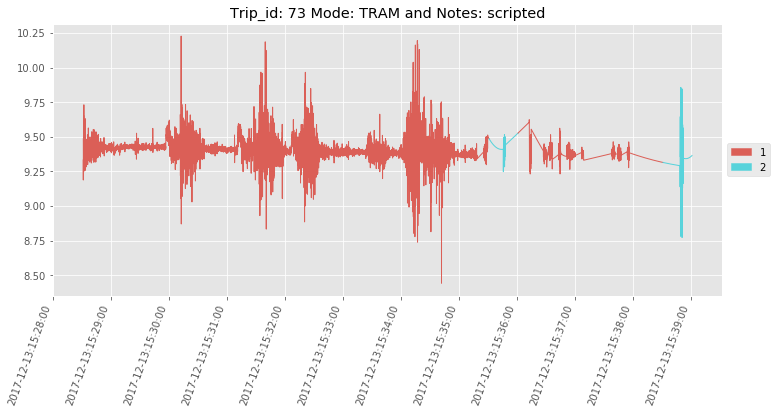

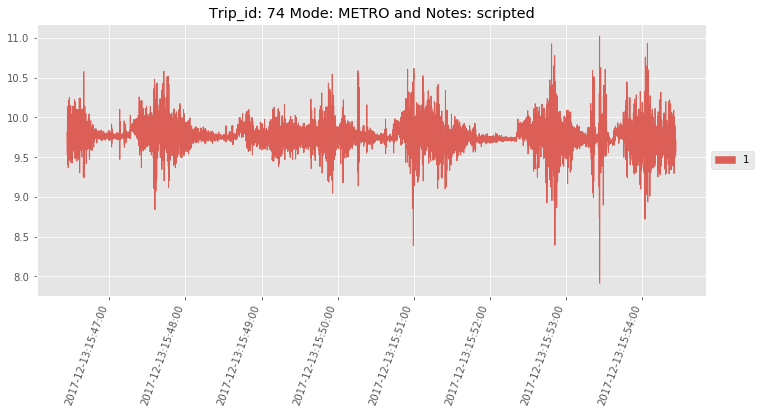

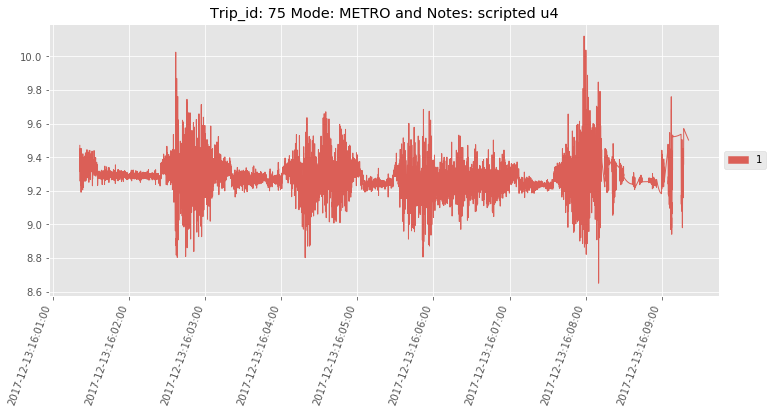

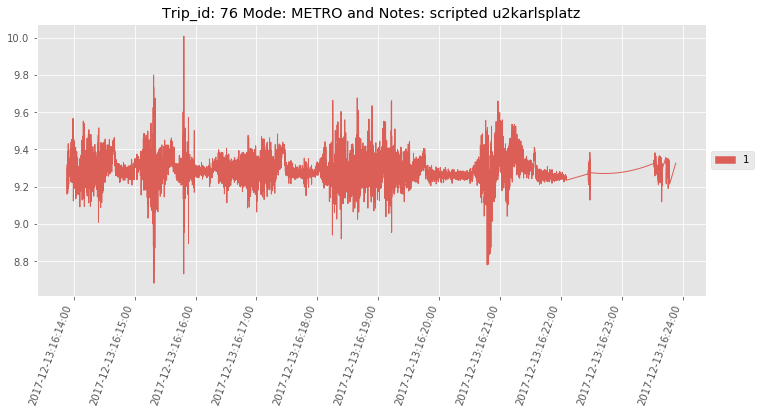

In [18]:
trips_unpacked = Preprocessor.unpack_all_trips(dfs)
plot_all_trips_with_cluster_coloring(trips_unpacked, distance_matrix)